# I - Introduction

Dans ce notebook nous explorons les images du jeu de données.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

import seaborn as sns

On récupère le DataFrame enregistré à la fin de l'exploration du texte.

In [6]:
df = pd.read_csv('../data/exploration/exploration.csv')
df.head(3)

productid  prdtypecode                                        designation  \
0  3804725264           10  Olivia: Personalisiertes Notizbuch / 150 Seite...   
1   436067568         2280  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
2   201115110           50  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   

                                         description  \
0                                                NaN   
1                                                NaN   
2  PILOT STYLE Touch Pen de marque Speedlink est ...   

                                               image  \
0  ../data/raw/images/image_train/image_126359704...   
1  ../data/raw/images/image_train/image_100814123...   
2  ../data/raw/images/image_train/image_938777978...   

                                 cleaned_designation  \
0  olivia: personalisiertes notizbuch 150 seiten ...   
1  journal des arts (le) n° 133 du 28/09/2001 l'a...   
2  grand stylet ergonomique bleu gamepad nintendo...   

                                 cleaned_description  \
0                                                NaN   
1                                                NaN   
2  pilot style touch pen de marque speedlink est ...   

                                                text  \
0  olivia: personalisiertes notizbuch 150 seiten ...   
1  journal des arts (le) n° 133 du 28/09/2001 l'a...   
2  grand stylet ergonomique bleu gamepad nintendo...   

                               hashed_image                     category  \
0  fbde1b7de24a0a658aa7fb4d5acd2d77f2cefe1f           Livres spécialisés   
1  3b89f1c531ac374c59083a79887408e1145d5003           Presse & Magazines   
2  6baca87dec4eade08a824edf99a300a64b8dd2e8  Accessoires & Périphériques   

             group  cleaned_description_len  is_label_issue detected_lang  \
0  Livres & Revues                        0           False            it   
1  Livres & Revues                        0           False            fr   
2       Jeux Vidéo                      669           False            fr   

   near_duplicated  
0            False  
1            False  
2            False

# II - Analyse des images

On définit des fonctions pour récupérer les images à partir des chemins et une fonction pour afficher des grilles d'images. Ensuite, nous affichons quelques images pour chaque catégorie de manière aléatoire.

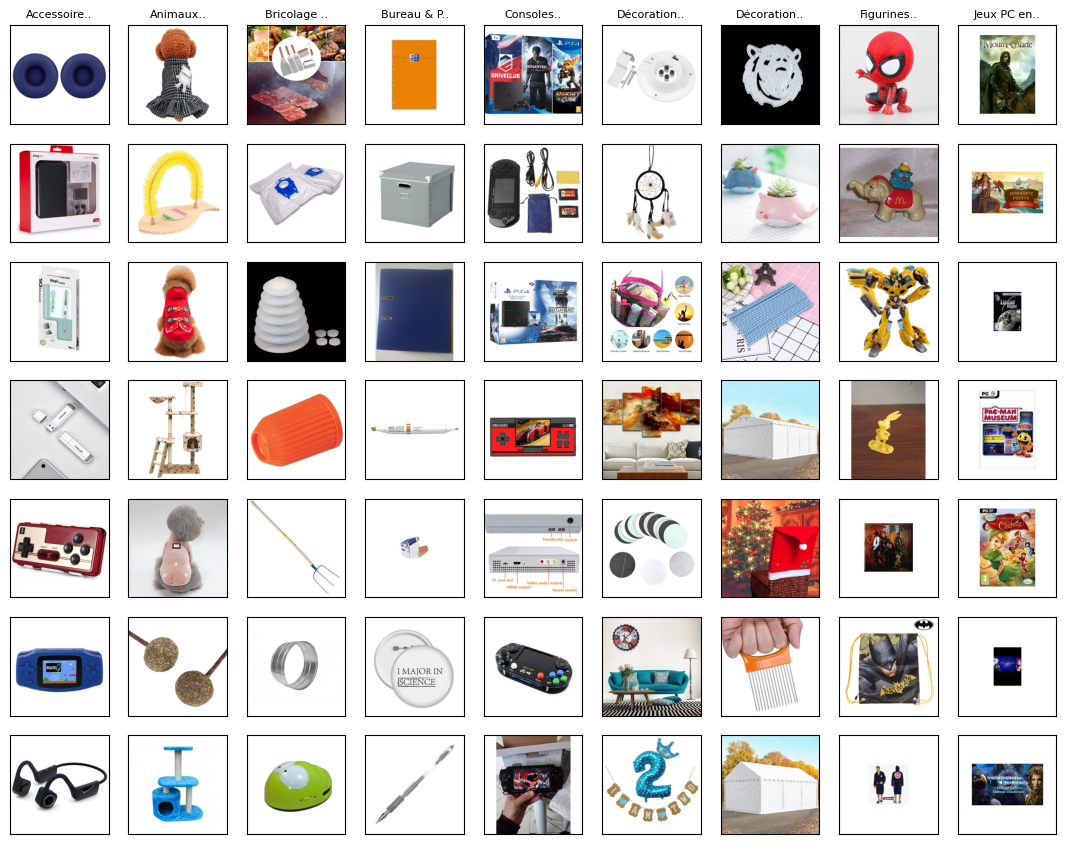

----------------------------------------------------------------------------------------------------------------------------------------------------


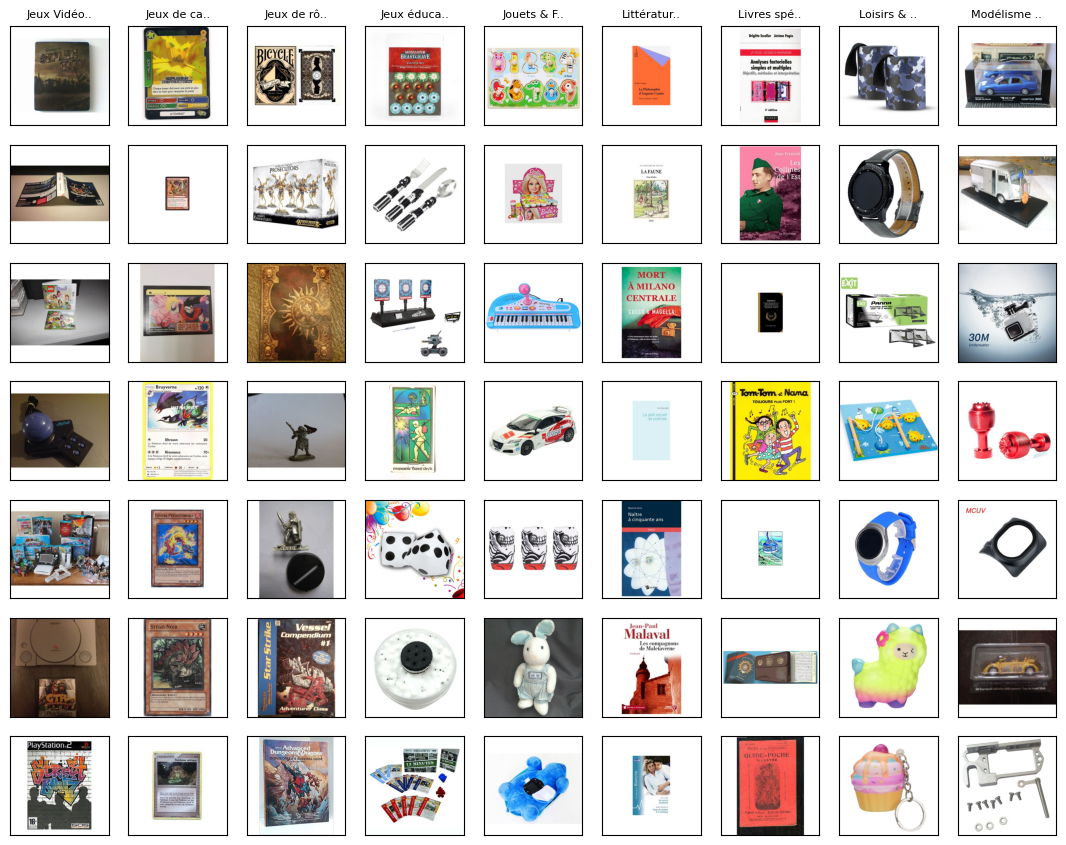

----------------------------------------------------------------------------------------------------------------------------------------------------


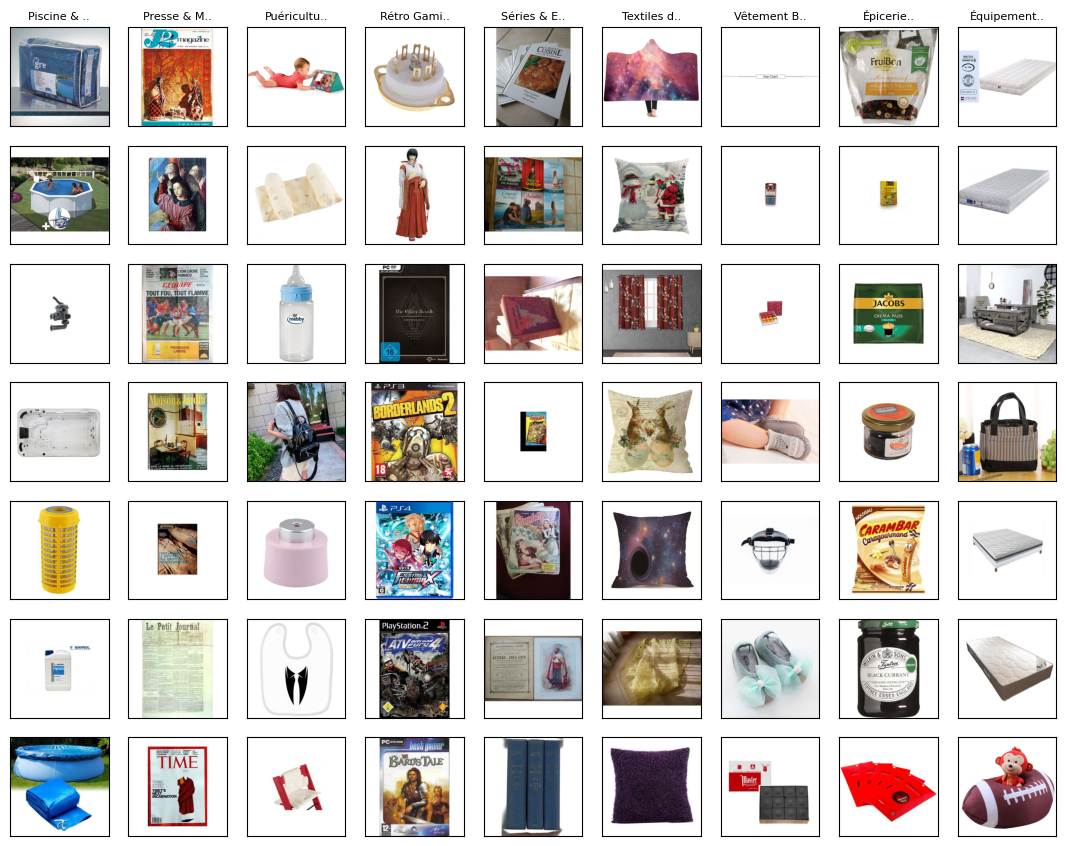

In [7]:
# max_load représente le nombre d'octet maximum chargé en mémoire 10**9 => 1 Go
# le nombre d'images retourné se fera en fonction de ce paramètre

def images_read(impath, dsize=(500,500), grayscale=False, max_load=10**9):
    n = len(impath)
    total_size = n*dsize[0]*dsize[1] if grayscale else n*dsize[0]*dsize[1]*3
    stop = int(n * (max_load/total_size)) if total_size > max_load else n
    images = []
    # si c'est une Series il faut reindexé par 0, ... ,n pour pouvoir utiliser les indices de la même manière qu'une liste
    if type(impath) == pd.Series:
        impath = impath.reset_index(drop=True)
    if grayscale:
        for i in range(stop):
            im = cv2.imread(impath[i], cv2.IMREAD_GRAYSCALE)
            images.append(cv2.resize(im, dsize = dsize))
    else:
        for i in range(stop):
            im = cv2.imread(impath[i], cv2.IMREAD_COLOR)
            # cv2 encode les images aux formats BGR,
            # on les transforme en RGB pour les afficher correctement avec matplotlib 
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            images.append(cv2.resize(im, dsize = dsize))
    return np.array(images)

def images_grid(images, nrows=5, ncols=10, cmap=None, titles=None, ordered_by_rows=True, axes_size=(1.5, 1.5)):
    fig, axes = plt.subplots(nrows, ncols, figsize=(axes_size[0]*ncols, axes_size[1]*nrows))
    axes = axes.flatten()
    if ordered_by_rows:
        axes_order = range(nrows*ncols)
    else:
        axes_order = [i*ncols + j for j in range(ncols) for i in range(nrows)]
    for i in range(nrows*ncols):
        k = axes_order[i]
        if i < len(images):
            axes[k].imshow(images[i], cmap=cmap)
            if titles:
                axes[k].set_title(titles[i], fontsize=8)
        axes[k].set_xticks([])
        axes[k].set_yticks([])
    plt.show()


N = 7  # nombre d'images par catégories

titles = []
paths = []

for cat in np.sort(df['category'].unique()):
    titles += [cat[:10]+'..'] + [''] * (N-1)
    paths += list(df[df['category'] == cat]['image'].sample(N, random_state=42))
images = images_read(paths)
images_grid(images[:9*N], N, 9, titles=titles[:9*N], ordered_by_rows=False)
print('-'*148)
images_grid(images[9*N:18*N], N, 9, titles=titles[9*N:18*N], ordered_by_rows=False)
print('-'*148)
images_grid(images[18*N:], N, 9, titles=titles[18*N:], ordered_by_rows=False)

Mis à part les catégories de livres et revues qui semblent avoir un cadrage permettant de détecter la forme rectangulaire, il semble être compliqué de determiner les éléments des photos qui caractérisent la catégorie d'un produit. Souvent les couleurs et les formes peuvent varier grandement au sein des catégories. Pour voir quelles catégories ont les images les plus stables nous pouvant afficher les écarts-types (pixel par pixel) de chaque catégorie. Nous allons également afficher leur moyenne pour detécter s'il y a des formes qui se distinguent pour certaines catégories.

-----------------------------------------------------------------  moyennes  -----------------------------------------------------------------


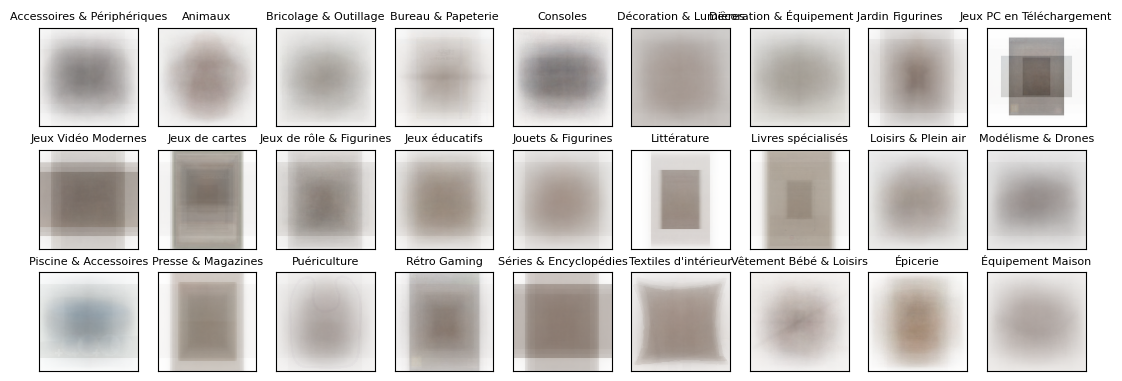

-----------------------------------------------------------------  écart-types  -----------------------------------------------------------------


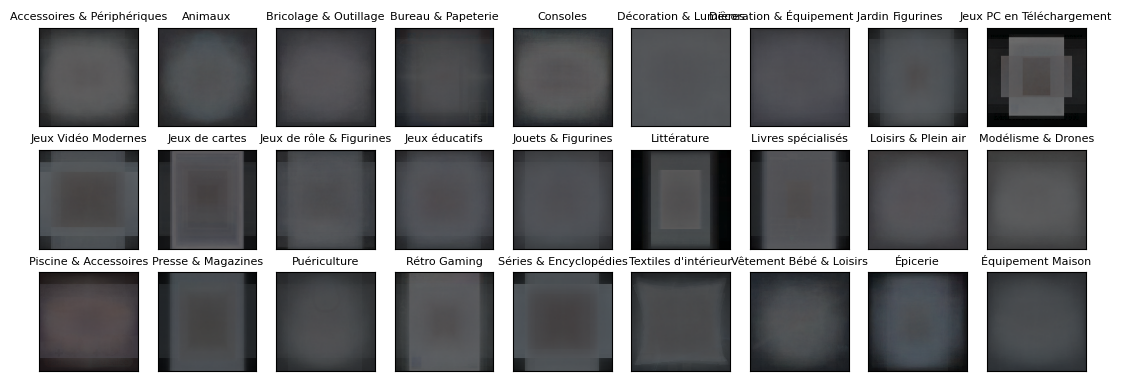

In [14]:
categories = sorted(df['category'].unique())
images_means = []
images_std = []
for cat in categories:
    images = images_read(df[df['category'] == cat]['image'], (100, 100))
    images_means.append(images.mean(axis=0).astype(int))
    images_std.append(images.std(axis=0).astype(int))

print('-'*65+"  moyennes  "+'-'*65)
images_grid(images_means, 3, 9, titles=categories)
print('-'*65+"  écart-types  "+'-'*65)
images_grid(images_std, 3, 9, titles=categories)

Nous constatons que les catégories où des formes ressortent le plus clairement sont celles des livres et des jeux PC. Par exemple pour la catégorie Littérature, deux formes principales apparaissent :
* un grand rectangle, qui pourrait correspondre à de grands ouvrages ou à des photos prises de très près ;
* un petit rectangle, peut-être lié à des livres de poche ou à des prises de vue plus éloignées.
  
On note également que l'image moyenne de la catégorie Piscine est globalement plus bleutée, ce qui reflète la dominante de couleur typique de ce type de scènes.
Le noir profond visible sur les bords des images représentant les écarts-types pour jeux PC et littérature indique que les pixels situés en périphérie varient très peu. En observant les images moyennes, on en déduit qu’ils sont presque toujours blancs.



# III - LDA
Nous allons maintenant projeter les images (réduites en 28x28 et en noir et blanc) sur un plan à partir des deux composantes principales de la LDA.

In [15]:
# fonction prise telle quelle du module "Méthodes de réduction de dimension - Manifold learning"

from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray_r', prefit = False):
    ax = ax or plt.gca()
    
    if not prefit :
        proj = model.fit_transform(data)
    else:
        proj = data
    ax.plot(proj[:, 0], proj[:, 1], '.b')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # On ne montre pas le points trop proches
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(cv2.resize(images[i], dsize = (28,28)), cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

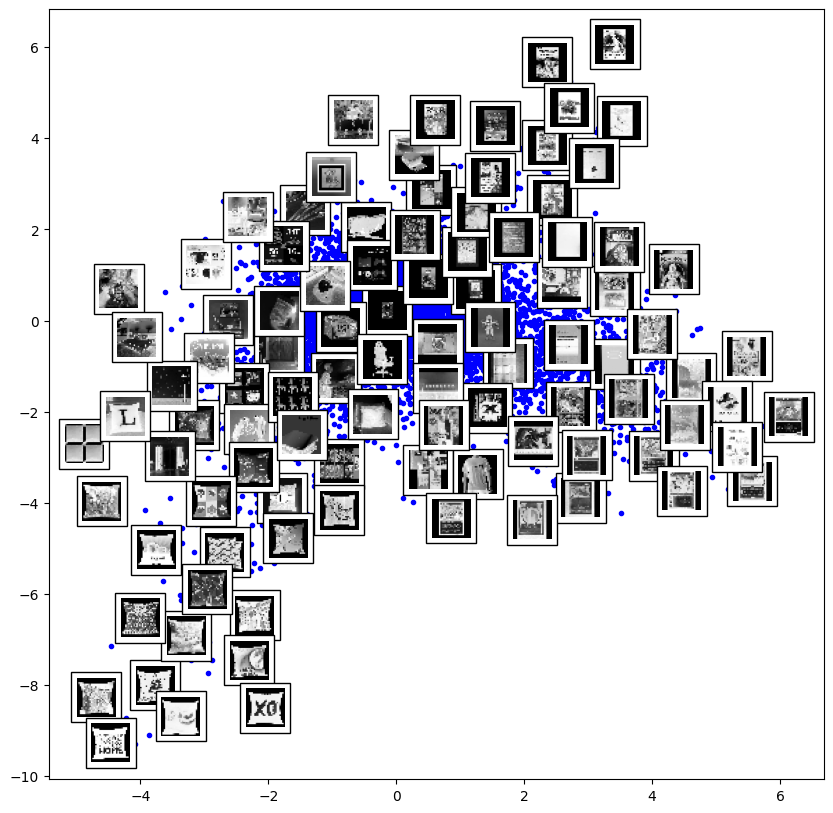

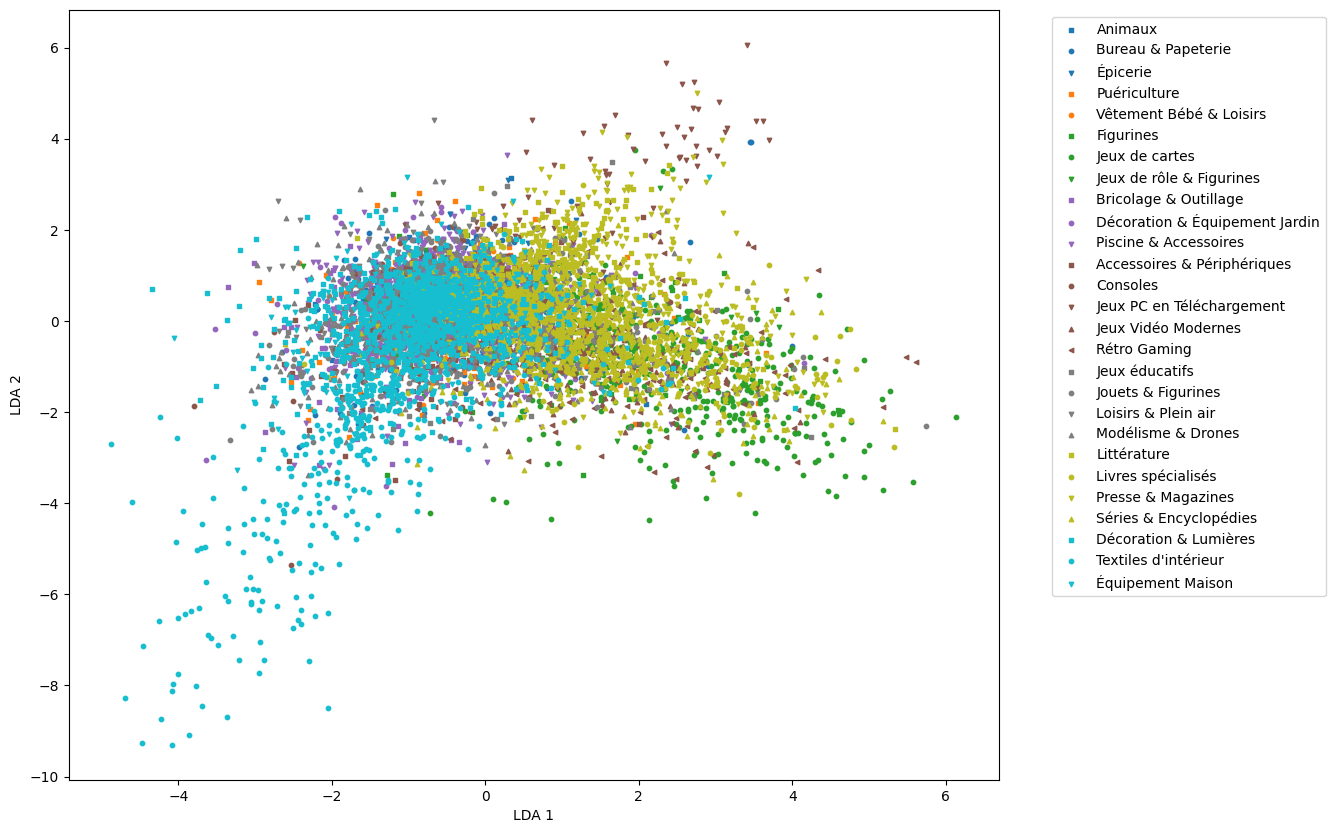

In [16]:
import matplotlib.markers as mmarkers

N = 10000
im28x28 = images_read(df['image'].iloc[:N], dsize=(28,28), grayscale=True)
im28x28 = im28x28.reshape((im28x28.shape[0], im28x28.shape[1]*im28x28.shape[2]))
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(im28x28, df['prdtypecode'][:N])
imt = lda.transform(im28x28)
fig, ax = plt.subplots(figsize=(10, 10))

# pour le nuage de points avec les images
plot_components(imt, lda, im28x28.reshape((-1,28,28)), prefit=True, ax=ax, thumb_frac=0.05)


# pour le deuxième nuage de points
data = pd.DataFrame({
    'x': imt[:, 0],
    'y': imt[:, 1],
    'groupe': df['group'].iloc[:len(imt)],
    'categorie': df['category'].iloc[:len(imt)]
})

groups = sorted(data['groupe'].unique())

cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in np.linspace(0, 1, len(groups))]
markers = list(mmarkers.MarkerStyle.markers.keys())[1:]

plt.figure(figsize=(12,10))

for i, group in enumerate(groups):
    cats = sorted(data[data['groupe']==group]['categorie'].unique())
    for j, cat in enumerate(cats):
        subset = data[(data["categorie"] == cat) & (data["groupe"] == group)]
        plt.scatter(subset["x"], subset['y'], color=colors[i], marker=markers[j], label=cat, s=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.show()

Seule la catégorie textile d'intérieur semble facilement se démarquer (en bas à gauche). Dans cette catégorie ce sont essentiellement les images de coussins et d'oreillers qui semblent être discriminées.
En haut à droite on voit des objets plus rectangulaires souvent des livres et des revues. Nous allons maintenant essayer la même chose avec l'utilisation du t-SNE.

# IV - t-SNE

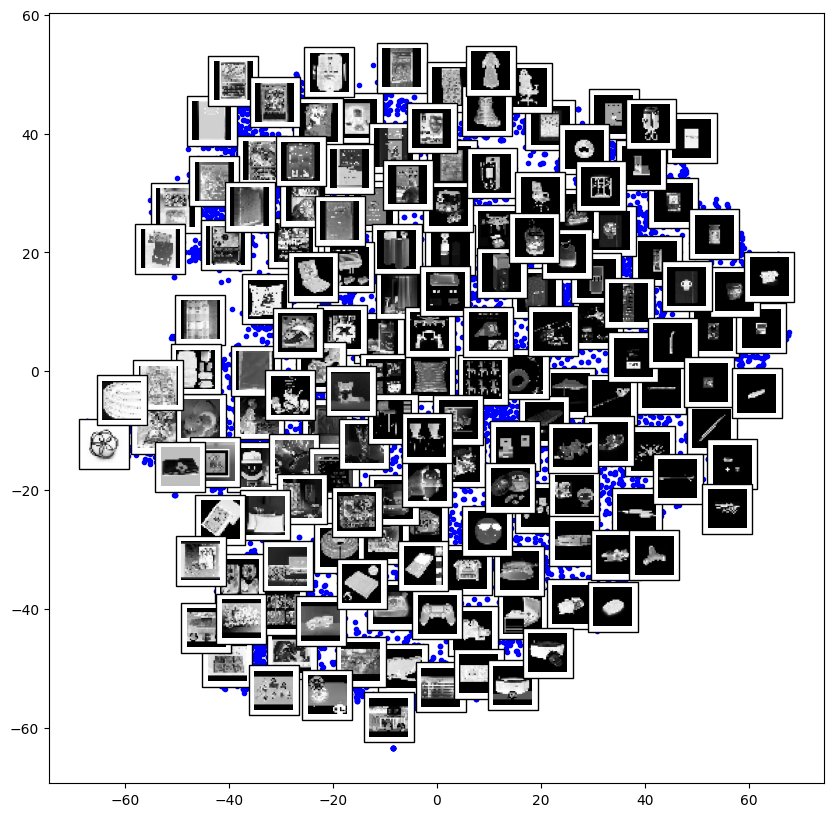

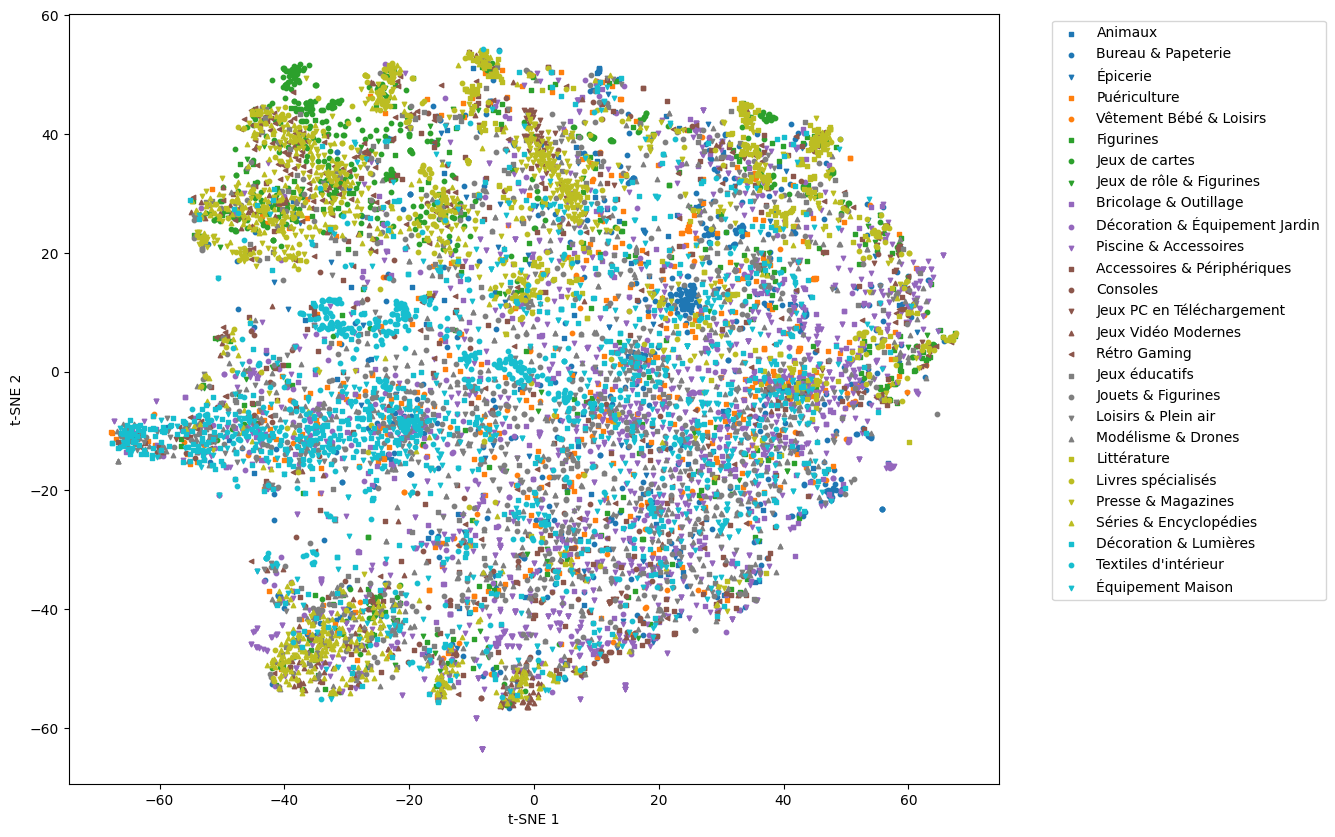

In [17]:
tsne = TSNE(n_components=2)
imt = tsne.fit_transform(im28x28)

fig, ax = plt.subplots(figsize=(10, 10))

# pour le nuage de points avec les images
plot_components(imt, tsne, im28x28[:N].reshape((-1,28,28)), prefit=True, ax=ax, thumb_frac=0.05)


# pour le deuxième nuage de points
data = pd.DataFrame({
    'x': imt[:, 0],
    'y': imt[:, 1],
    'groupe': df['group'].iloc[:len(imt)],
    'categorie': df['category'].iloc[:len(imt)]
})

groups = sorted(data['groupe'].unique())

cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in np.linspace(0, 1, len(groups))]
markers = list(mmarkers.MarkerStyle.markers.keys())[1:]

plt.figure(figsize=(12,10))

for i, group in enumerate(groups):
    cats = sorted(data[data['groupe']==group]['categorie'].unique())
    for j, cat in enumerate(cats):
        subset = data[(data["categorie"] == cat) & (data["groupe"] == group)]
        plt.scatter(subset["x"], subset['y'], color=colors[i], marker=markers[j], label=cat, s=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

Ici on voit que l'axe des absisses permet de distinguer les photos foncées des photos claires.
Pour l'axe des ordonnées c'est moins évident mais il semble que les objets plus 'aplatis' sont en bas et ceux qui sont plus en hauteur sont en haut.